In [1]:
import numpy as np
from splinv import detect
from splinv import hmod
from splinv import darkmapper
from splinv.grid import Cartesian
from configparser import ConfigParser
import splinv
import time

""" Test sparse reconstruction of weak lensing dark map
"""
# configuration
configName  =   'test_mock_catalog_atom.ini'
parser      =   ConfigParser()
parser.read(configName)

# halo simulation
z_h1     =  0.2425
z_h2     =  0.1
log_m   =  14.745
M_200   =  10.**(log_m)
conc    =  2.
halo1    =  hmod.nfwTJ03(mass=M_200,conc=conc,redshift=z_h1,ra=-935.,dec=1100.)
halo2    =  hmod.nfwTJ03(mass=M_200,conc=conc,redshift=z_h2,ra=800,dec=-1200)

generating mock catalog this way has the freedom of moving the halo around. 

In [2]:
# Reconstruction Init
parser.set('sparse','mu','3e-4')            #step size for gradient descent
parser.set('lens','resolve_lim','0.02')     #pix
parser.set('lens','rs_base','%s' %halo1.rs)  #Mpc/h
parser.set('sparse','nframe','2' )

# Pixelation
Grid    =   Cartesian(parser)
lensKer1=   Grid.lensing_kernel(deltaIn=False)


general_grid    =   splinv.hmod_v2.triaxialJS02_grid_mock(parser)
kappa1   =   general_grid.add_halo(halo1)[0]
kappa2   =   general_grid.add_halo(halo2)[0]
shear1   =   general_grid.add_halo(halo1)[1]
shear2   =   general_grid.add_halo(halo2)[1]
gErr    =   np.ones(Grid.shape)*0.05

totalshear = shear1 + shear2

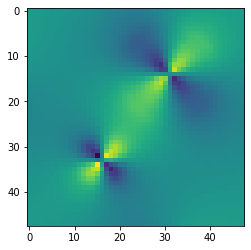

In [3]:
import matplotlib.pyplot as plt
plt.imshow(shear1[2].imag+shear2[2].imag)

In [4]:
s = time.time()
dmapper =   darkmapper(parser,totalshear.real, totalshear.imag, gErr,lensKer1)

dmapper.lbd=8.      # Lasso penalty
dmapper.lcd=0.      # Ridge penalty in Elastic net
dmapper.nonNeg=True # using non-negative Lasso
dmapper.clean_outcomes()
dmapper.fista_gradient_descent_fast(3000) # run 3000 steps
#w   =   dmapper.adaptive_lasso_weight(gamma=2.) # determine the apaptive weight
#dmapper.fista_gradient_descent(3000,w=w)   
e = time.time()# run adaptive lasso
print(e-s)

25.436212062835693


In [5]:
s = time.time()
dmapper.mu=3e-3     # step size for gradient descent
for _ in range(3):  # redo apaptive lasso
    w   =   dmapper.adaptive_lasso_weight(gamma=2.)
    dmapper.fista_gradient_descent_fast(3000,w=w)
dmapper.reconstruct()
e = time.time()
print(e-s)

74.91858100891113


In [6]:
Grid.zlcgrid

array([0.0625, 0.1075, 0.1525, 0.1975, 0.2425, 0.2875, 0.3325, 0.3775,
       0.4225, 0.4675])

In [13]:
c1  =   detect.local_maxima_3D(dmapper.deltaR)
print(c1)
logm_est1=   np.log10((dmapper.alphaR*dmapper._w)[2,0,14,31])+14.
logm_est2=   np.log10((dmapper.alphaR*dmapper._w)[6,0,33,16])+14.

(array([[ 2, 14, 31],
       [ 6, 33, 16]]), array([59.2010637 , 38.19097062]))


it worked i guess

In [14]:
print(logm_est1)
print(logm_est2)
print(log_m)
#when c=4, the result only agrees to unit digit, it also seems there are 2 halos in the lower redshift.

14.982248708949992
15.049198739461625
14.745


In [9]:
print(dmapper.deltaR.shape)

(10, 48, 48)


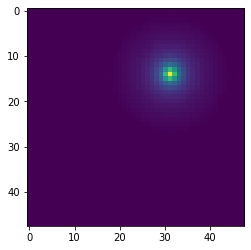

In [16]:
import matplotlib.pyplot as plt
plt.imshow(dmapper.deltaR[2])

(10, 2, 48, 48)


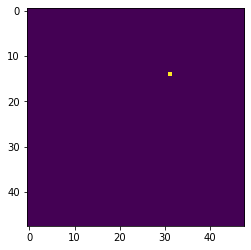

In [17]:
print(dmapper.alphaR.shape)
plt.imshow(dmapper.alphaR[2,0]) #only this is non-empty

In [12]:
print(np.max(dmapper.alphaR[4,0]))

0.0


In [11]:
print(dmapper.diff)

[6.27627357e-10 6.25744532e-10 7.99644101e-10 ... 9.65818659e-14
 9.48426966e-14 9.28716382e-14]
